In [2]:
from PIL import Image, ImageDraw
import random
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

def matrix(string):
    return np.array(list(map(int, string.replace('\xa0','0').split(','))))

class Nonogram:
    def __init__(self, height = 30, width = 30, step_size = 25):
        
        image = Image.new(mode='L', size=(height* step_size, width * step_size), color=255)

        # Draw some lines
        draw = ImageDraw.Draw(image)
        y_start = 0
        y_end = image.height

        for x in range(0, image.width, step_size):
            line = ((x, y_start), (x, y_end))
            draw.line(line, fill=128)

        x_start = 0
        x_end = image.width

        for y in range(0, image.height, step_size):
            line = ((x_start, y), (x_end, y))
            draw.line(line, fill=128)
        
        self.step_size = step_size
        self.imgdraw = ImageDraw.Draw(image)
        self.image = image  
        
    def color(self,i,j):        
        self.imgdraw.rectangle([(i * self.step_size, j * self.step_size),((i + 1) * self.step_size,(j + 1) *self.step_size)], fill = 0)
    

    def draw(self,i,j,text):
        i= (i + 0.4) * self.step_size
        j= (j + 0.3) * self.step_size
        self.imgdraw.text((i,j), text, fill =0)

    def matrixdraw(self,M, start = (0,0)):
        for i, m in enumerate(M):
            for j, v in enumerate(m):
                self.draw(i + start[0],j + start[1],str(v) if v != 0 else '')


class Matrix(Nonogram):
    def __init__(self,data):
        size = (data['sizeCol'],data['sizeRow'])
        c = matrix(data['colClues']).reshape(size[0],-1).T
        r = matrix(data['rowClues']).reshape(-1,size[1]).T
        super().__init__(r.shape[0] + c.shape[0],r.shape[1] + c.shape[1])
        self.matrixdraw(r, start = (c.shape[0],0))
        self.matrixdraw(c, start = (0,r.shape[1]))
        self.emptyshape = (c.shape[0],r.shape[1])
        self.c = c.T
        self.r = r
        self.difficulty = data['difficulty']
        self.shape = (c.shape[1],r.shape[0])
        self.solution = data['solution']
        self.imagecopy = self.image.copy()
        self.R = [{'len':len([c for c in r if c!=0]),
                 'sum': sum(r),
                 'entity':np.array([[c] for c in r if c!=0])} for r in self.r]
        self.C = [{'len':len([c for c in r if c!=0]),
                 'sum': sum(r),
                 'entity':np.array([[c] for c in r if c!=0])} for r in self.c]
        
    def Mdraw(self,M = None):
        if(M is None):
            M = np.zeros(self.shape)
            
        self.image = self.imagecopy.copy()
        self.imgdraw = ImageDraw.Draw(self.image)
        M = M.T
        for i, m in enumerate(M):
            for j, v in enumerate(m):
                if(v):
                    self.color(i + self.emptyshape[0],j + self.emptyshape[1])
        return self.image
                    



In [3]:
import cProfile
import pstats
def Stats(f):
    profile = cProfile.Profile()
    profile.runcall(f)
    ps = pstats.Stats(profile)
    ps.print_stats()

In [4]:
class AIC:
    def __init__(self, M):
        mask = np.ones(M.shape,dtype=bool)
        nmask = np.ones(M.shape,dtype=bool)
        for i,c in enumerate(M.C):
            mask[i][-c['sum']+1:] = False
            nmask[i][c['len']:] = False
        self.mask = mask
        self.nmask = nmask      
        self.M = M
        self.shape = M.shape
        
    def generate(self):
        R = (np.argsort(1-np.random.rand(*self.shape)*self.mask)+1) * self.nmask
        g = np.zeros(self.shape, dtype = bool)
        for i,r in enumerate(R):
            for j in r:
                if(j):
                     g[i][j-1] = True
        return g
            
        
    def binify(arr,n):
        return (np.array([*np.binary_repr(arr).zfill(n)]) == '1')[::-1]
    
    def unmaskop(row, arr):
        (iones,) = np.where(row)
        shift = np.roll(arr,1)
        shift[0] = 0
        iones = 2**(iones +np.cumsum(shift) )      
        return AIC.binify(np.sum((2**(arr)-1)*iones),len(row))
    
    def unmask(self,M):
        return np.vstack([AIC.unmaskop(m,n[n!=0]) for m,n in zip(M,self.M.c)])


    def crossover(self,M1,M2):
        X = M1 ^ M2
        R = np.argsort(1-(np.random.rand(*self.shape)*X))        
        g = np.zeros(self.shape, dtype = bool)
        for i,(m,r) in enumerate(zip(np.sum(X,1)//2,R)):
            for j in r[:m]:
              g[i,j] = True
                
        return g | (M1 & M2)        
    
    
    def scmutate(c,nm):
        (one,) = np.nonzero(c)
        if(nm > len(one)):
            return c
        m = np.random.choice(np.arange(len(one)),nm,replace=False)
        k = (random.random()>0.5)*2-1
        c[one[m]] = False
        c[one[m]+ k] = True
        
        return c
    
    def vscmutate(mask,c,*args,**kwargs):
        m = AIC.scmutate(np.copy(c),*args,**kwargs) & mask
        if np.sum(m)!=np.sum(c): return c        
        return m
    
    def mutate(self,A,mrate = 0.95,mstd=1):        
        while True:
            if(random.random() > mrate):
                break
            i = np.random.choice(np.arange(len(A)))
            A[i] = AIC.vscmutate(self.mask[i],A[i],np.abs(int(np.random.normal(0,mstd)))+1)
        return A
    
class AIR(AIC):
    def __init__(self, M):
        shape = (M.shape[1],M.shape[0])
        mask = np.ones(shape,dtype=bool)
        nmask = np.ones(shape,dtype=bool)
        for i,c in enumerate(M.R):
            mask[i][-c['sum']+1:] = False
            nmask[i][c['len']:] = False
        self.mask = mask
        self.nmask = nmask      
        self.M = M
        self.shape = shape

    def unmask(self,M):
        return np.vstack([AIC.unmaskop(m,n[n!=0]) for m,n in zip(M,self.M.r)])
    

In [5]:
class AI:
    def __init__(self,M,aic,air):
        self.M = M
        self.aic = aic
        self.air = air
        self._C = aic.generate()
        self._R = air.generate()
        self.goal = np.sum(M.c)
        
    @property
    def C(self):
        return self.aic.unmask(self._C)
    
    @property
    def R(self):
        return self.air.unmask(self._R).T   
    
    @property
    def fitness(self):
        return np.sum(self.R & self.C)
    
    @np.vectorize
    def crossover(self, ai2, mrate = 0.95):        
        child = AI(self.M,self.aic,self.air)
        
        
        C = self.aic.crossover(self._C,ai2._C)
        R = self.air.crossover(self._R,ai2._R)
        C,R = self.aic.mutate(C,mrate = mrate),self.air.mutate(R,mrate = mrate)
        child._R = R 
        child._C = C
        
        return child
        
        

In [7]:
import pandas as pd
import numpy as np
df = pd.read_csv('nonogram.csv')
#M = Matrix(df.iloc[300])
M = Matrix(df.iloc[2494])
M.solution,M.difficulty

('http://static.nonograms.org/files/nonograms/large/statuya_svobodi_12_1_1p.png',
 '9/10')

***goal**** 
368
max fitness:  177 191


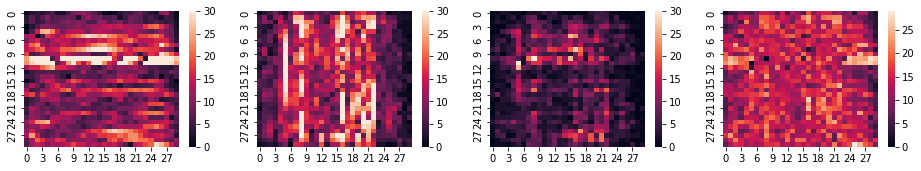

max fitness:  178 190
max fitness:  173 195
max fitness:  180 188
max fitness:  182 186
max fitness:  188 180
max fitness:  187 181
max fitness:  181 187
max fitness:  188 180
max fitness:  197 171
max fitness:  187 181
max fitness:  197 171
max fitness:  186 182
max fitness:  195 173
max fitness:  197 171
max fitness:  199 169
max fitness:  199 169
max fitness:  196 172
max fitness:  194 174
max fitness:  198 170
max fitness:  196 172
max fitness:  197 171
max fitness:  200 168
max fitness:  201 167
max fitness:  197 171
max fitness:  203 165
max fitness:  202 166
max fitness:  201 167
max fitness:  206 162
max fitness:  203 165
max fitness:  204 164


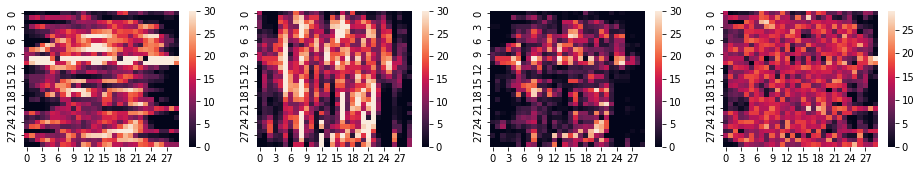

max fitness:  209 159
max fitness:  199 169
max fitness:  205 163
max fitness:  210 158
max fitness:  207 161
max fitness:  200 168
max fitness:  206 162
max fitness:  205 163
max fitness:  206 162
max fitness:  206 162
max fitness:  210 158
max fitness:  205 163
max fitness:  205 163
max fitness:  204 164
max fitness:  208 160
max fitness:  205 163
max fitness:  211 157
max fitness:  212 156
max fitness:  210 158
max fitness:  208 160
max fitness:  212 156
max fitness:  209 159
max fitness:  209 159
max fitness:  209 159
max fitness:  211 157
max fitness:  213 155
max fitness:  208 160
max fitness:  212 156
max fitness:  208 160
max fitness:  209 159


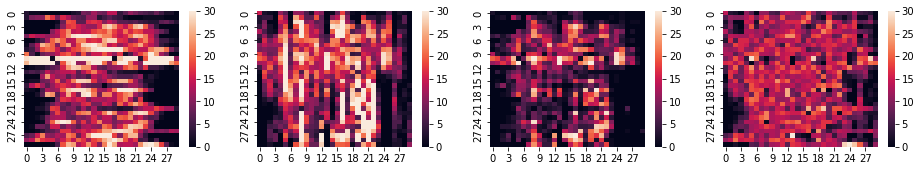

max fitness:  215 153
max fitness:  211 157
max fitness:  214 154
max fitness:  209 159
max fitness:  211 157
max fitness:  210 158
max fitness:  211 157
max fitness:  212 156
max fitness:  216 152
max fitness:  212 156
max fitness:  215 153
max fitness:  216 152
max fitness:  213 155
max fitness:  214 154
max fitness:  217 151
max fitness:  214 154
max fitness:  214 154
max fitness:  213 155
max fitness:  212 156
max fitness:  214 154
max fitness:  224 144
max fitness:  214 154
max fitness:  218 150
max fitness:  212 156
max fitness:  215 153
max fitness:  222 146
max fitness:  213 155
max fitness:  218 150
max fitness:  216 152
max fitness:  218 150


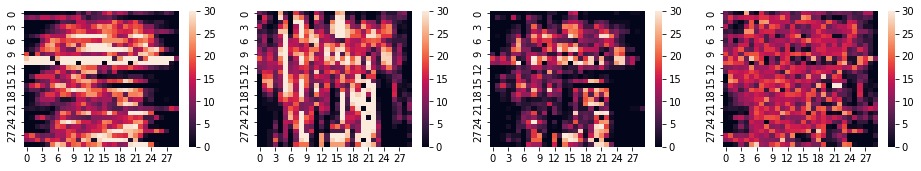

max fitness:  218 150
max fitness:  215 153
max fitness:  216 152
max fitness:  218 150
max fitness:  217 151
max fitness:  221 147
max fitness:  217 151
max fitness:  220 148
max fitness:  217 151
max fitness:  219 149
max fitness:  216 152
max fitness:  216 152
max fitness:  218 150
max fitness:  223 145
max fitness:  223 145
max fitness:  219 149
max fitness:  217 151
max fitness:  216 152
max fitness:  216 152
max fitness:  219 149
max fitness:  218 150
max fitness:  213 155
max fitness:  216 152
max fitness:  224 144
max fitness:  217 151
max fitness:  217 151
max fitness:  212 156
max fitness:  213 155
max fitness:  219 149
max fitness:  219 149


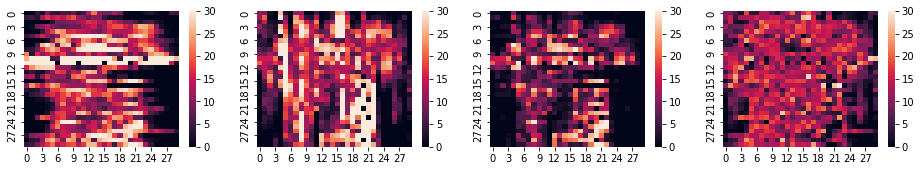

max fitness:  225 143
max fitness:  220 148
max fitness:  220 148
max fitness:  220 148
max fitness:  218 150
max fitness:  224 144
max fitness:  225 143
max fitness:  216 152
max fitness:  222 146
max fitness:  216 152
max fitness:  220 148
max fitness:  220 148
max fitness:  222 146
max fitness:  220 148
max fitness:  224 144
max fitness:  224 144
max fitness:  228 140
max fitness:  222 146
max fitness:  225 143
max fitness:  222 146
max fitness:  222 146
max fitness:  226 142
max fitness:  225 143
max fitness:  226 142
max fitness:  226 142
max fitness:  224 144
max fitness:  223 145
max fitness:  221 147
max fitness:  224 144
max fitness:  222 146


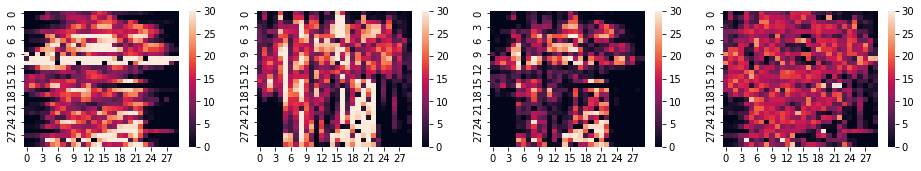

max fitness:  221 147
max fitness:  224 144
max fitness:  225 143
max fitness:  223 145
max fitness:  226 142
max fitness:  229 139
max fitness:  232 136
max fitness:  223 145
max fitness:  226 142
max fitness:  226 142
max fitness:  225 143
max fitness:  226 142
max fitness:  223 145
max fitness:  222 146
max fitness:  227 141
max fitness:  225 143
max fitness:  225 143
max fitness:  227 141
max fitness:  223 145
max fitness:  222 146
max fitness:  224 144
max fitness:  225 143
max fitness:  220 148
max fitness:  225 143
max fitness:  232 136
max fitness:  226 142
max fitness:  226 142
max fitness:  222 146
max fitness:  221 147
max fitness:  219 149


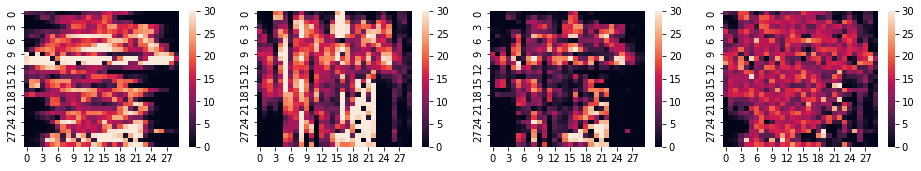

max fitness:  223 145
max fitness:  224 144
max fitness:  221 147
max fitness:  223 145
max fitness:  223 145
max fitness:  225 143
max fitness:  224 144
max fitness:  221 147
max fitness:  223 145
max fitness:  224 144
max fitness:  223 145
max fitness:  222 146
max fitness:  223 145
max fitness:  225 143
max fitness:  222 146
max fitness:  232 136
max fitness:  224 144
max fitness:  233 135
max fitness:  224 144
max fitness:  223 145
max fitness:  227 141
max fitness:  223 145
max fitness:  221 147
max fitness:  222 146
max fitness:  220 148
max fitness:  219 149
max fitness:  226 142
max fitness:  225 143
max fitness:  221 147
max fitness:  222 146


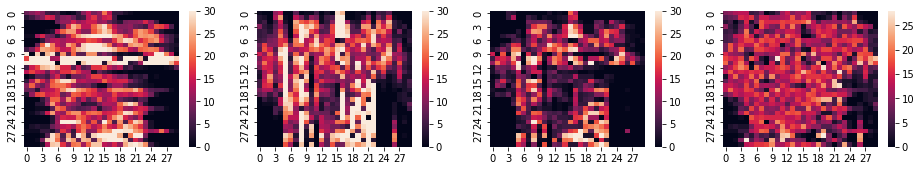

max fitness:  222 146
max fitness:  222 146
max fitness:  223 145
max fitness:  218 150
max fitness:  224 144
max fitness:  218 150
max fitness:  220 148
max fitness:  220 148
max fitness:  231 137
max fitness:  222 146
max fitness:  231 137
max fitness:  226 142
max fitness:  226 142
max fitness:  224 144
max fitness:  229 139
max fitness:  228 140
max fitness:  223 145
max fitness:  230 138
max fitness:  230 138
max fitness:  227 141
max fitness:  228 140
max fitness:  227 141
max fitness:  222 146
max fitness:  223 145
max fitness:  225 143
max fitness:  227 141
max fitness:  219 149
max fitness:  225 143
max fitness:  222 146
max fitness:  225 143


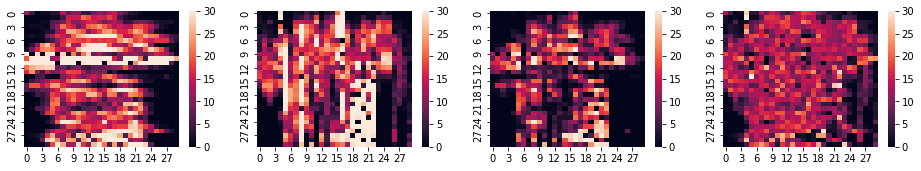

max fitness:  224 144
max fitness:  223 145
max fitness:  221 147
max fitness:  221 147
max fitness:  226 142
max fitness:  229 139
max fitness:  226 142
max fitness:  224 144
max fitness:  223 145
max fitness:  224 144
max fitness:  225 143
max fitness:  225 143
max fitness:  227 141
max fitness:  225 143
max fitness:  223 145
max fitness:  225 143
max fitness:  226 142
max fitness:  234 134
max fitness:  224 144
max fitness:  225 143
max fitness:  227 141
max fitness:  226 142
max fitness:  226 142
max fitness:  227 141
max fitness:  226 142
max fitness:  223 145
max fitness:  223 145
max fitness:  227 141
max fitness:  231 137
max fitness:  227 141


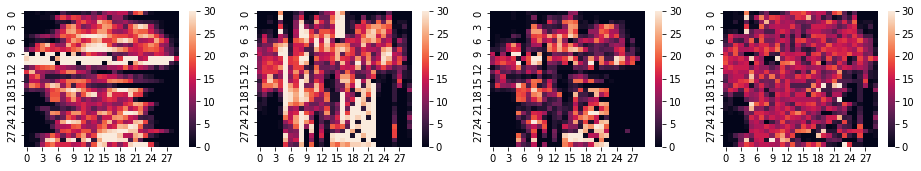

max fitness:  225 143
max fitness:  224 144
max fitness:  225 143
max fitness:  222 146
max fitness:  220 148
max fitness:  223 145
max fitness:  224 144
max fitness:  225 143
max fitness:  226 142
max fitness:  227 141
max fitness:  224 144
max fitness:  226 142
max fitness:  224 144
max fitness:  225 143
max fitness:  226 142
max fitness:  226 142
max fitness:  222 146
max fitness:  225 143
max fitness:  223 145
max fitness:  226 142
max fitness:  223 145
max fitness:  221 147
max fitness:  223 145
max fitness:  221 147
max fitness:  225 143
max fitness:  227 141
max fitness:  227 141
max fitness:  227 141
max fitness:  221 147
max fitness:  222 146


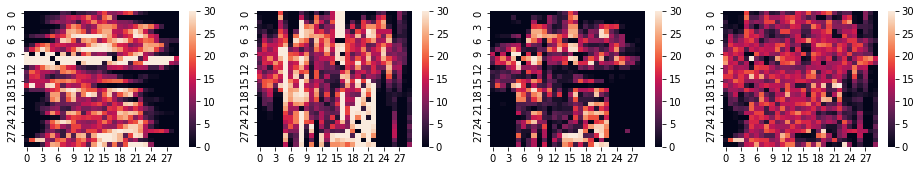

max fitness:  221 147
max fitness:  224 144
max fitness:  223 145
max fitness:  227 141
max fitness:  220 148
max fitness:  226 142
max fitness:  228 140
max fitness:  224 144
max fitness:  225 143
max fitness:  223 145
max fitness:  226 142
max fitness:  227 141
max fitness:  227 141
max fitness:  223 145
max fitness:  218 150
max fitness:  219 149
max fitness:  220 148
max fitness:  226 142
max fitness:  226 142
max fitness:  218 150
max fitness:  230 138
max fitness:  223 145
max fitness:  226 142
max fitness:  222 146
max fitness:  220 148
max fitness:  225 143
max fitness:  225 143
max fitness:  222 146
max fitness:  224 144
max fitness:  224 144


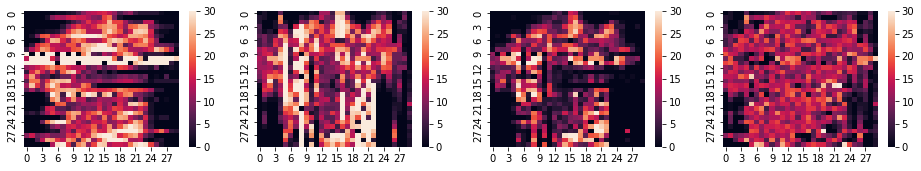

max fitness:  221 147
max fitness:  225 143
max fitness:  225 143
max fitness:  225 143
max fitness:  228 140
max fitness:  223 145
max fitness:  226 142
max fitness:  226 142
max fitness:  228 140
max fitness:  224 144
max fitness:  233 135
max fitness:  225 143
max fitness:  228 140
max fitness:  228 140
max fitness:  233 135
max fitness:  229 139
max fitness:  235 133
max fitness:  234 134
max fitness:  230 138
max fitness:  230 138
max fitness:  229 139
max fitness:  233 135
max fitness:  239 129
max fitness:  230 138
max fitness:  229 139
max fitness:  227 141
max fitness:  234 134
max fitness:  229 139
max fitness:  225 143
max fitness:  227 141


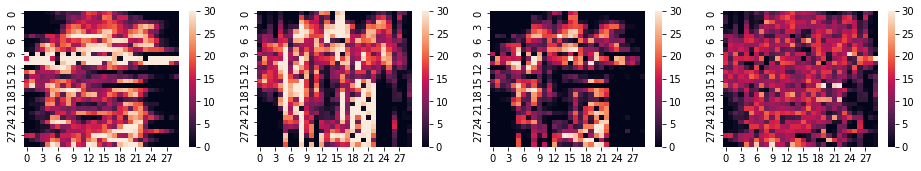

max fitness:  230 138
max fitness:  225 143
max fitness:  230 138
max fitness:  230 138
max fitness:  226 142
max fitness:  226 142
max fitness:  226 142
max fitness:  227 141
max fitness:  224 144
max fitness:  223 145
max fitness:  227 141
max fitness:  235 133
max fitness:  224 144
max fitness:  232 136
max fitness:  227 141
max fitness:  227 141
max fitness:  229 139
max fitness:  227 141
max fitness:  227 141
max fitness:  228 140
max fitness:  230 138
max fitness:  233 135
max fitness:  227 141
max fitness:  229 139
max fitness:  223 145
max fitness:  226 142
max fitness:  226 142
max fitness:  223 145
max fitness:  230 138
max fitness:  225 143


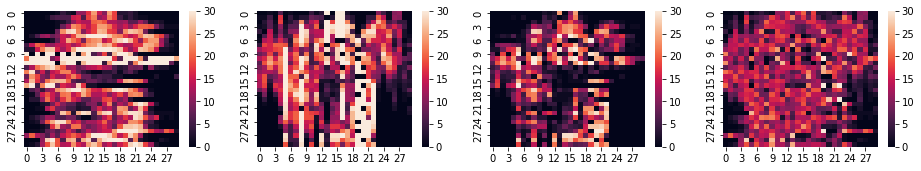

max fitness:  227 141
max fitness:  226 142
max fitness:  227 141
max fitness:  227 141
max fitness:  222 146
max fitness:  225 143
max fitness:  224 144
max fitness:  227 141
max fitness:  224 144
max fitness:  227 141
max fitness:  230 138
max fitness:  227 141
max fitness:  227 141
max fitness:  229 139
max fitness:  227 141
max fitness:  229 139
max fitness:  228 140
max fitness:  229 139
max fitness:  227 141
max fitness:  220 148
max fitness:  224 144
max fitness:  226 142
max fitness:  226 142
max fitness:  228 140
max fitness:  228 140
max fitness:  227 141
max fitness:  226 142
max fitness:  226 142
max fitness:  226 142
max fitness:  221 147


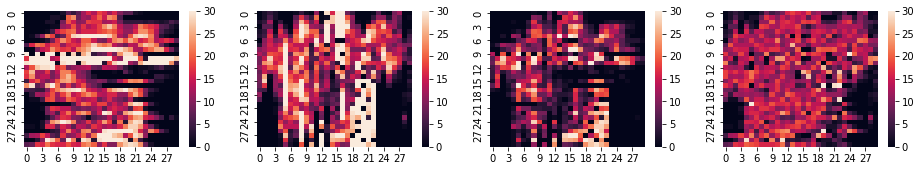

max fitness:  229 139
max fitness:  225 143
max fitness:  222 146
max fitness:  225 143
max fitness:  231 137
max fitness:  226 142
max fitness:  232 136
max fitness:  228 140
max fitness:  230 138
max fitness:  229 139
max fitness:  225 143
max fitness:  226 142
max fitness:  226 142
max fitness:  225 143
max fitness:  231 137
max fitness:  227 141
max fitness:  223 145
max fitness:  224 144
max fitness:  230 138
max fitness:  225 143
max fitness:  224 144
max fitness:  227 141
max fitness:  224 144
max fitness:  224 144
max fitness:  226 142
max fitness:  226 142
max fitness:  226 142
max fitness:  230 138
max fitness:  225 143
max fitness:  228 140


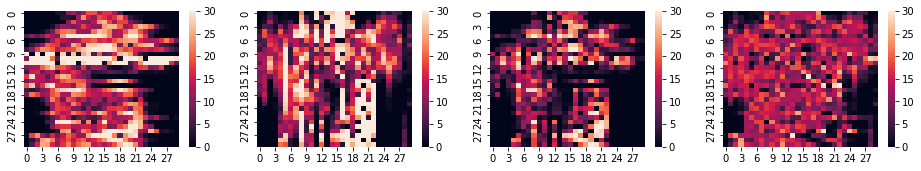

max fitness:  225 143
max fitness:  230 138
max fitness:  228 140
max fitness:  225 143
max fitness:  231 137
max fitness:  229 139
max fitness:  229 139
max fitness:  224 144
max fitness:  223 145
max fitness:  225 143
max fitness:  227 141
max fitness:  227 141
max fitness:  228 140
max fitness:  227 141
max fitness:  224 144
max fitness:  225 143
max fitness:  231 137
max fitness:  227 141
max fitness:  231 137
max fitness:  230 138
max fitness:  228 140
max fitness:  228 140
max fitness:  229 139
max fitness:  228 140
max fitness:  228 140
max fitness:  233 135
max fitness:  228 140
max fitness:  231 137
max fitness:  228 140
max fitness:  228 140


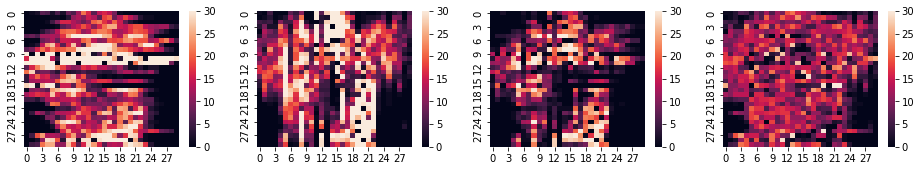

max fitness:  230 138
max fitness:  227 141
max fitness:  226 142
max fitness:  227 141
max fitness:  231 137
max fitness:  238 130
max fitness:  231 137
max fitness:  224 144
max fitness:  226 142
max fitness:  229 139
max fitness:  232 136
max fitness:  224 144
max fitness:  227 141
max fitness:  226 142
max fitness:  230 138
max fitness:  225 143
max fitness:  231 137
max fitness:  224 144
max fitness:  225 143
max fitness:  226 142
max fitness:  237 131
max fitness:  230 138
max fitness:  227 141
max fitness:  234 134
max fitness:  227 141
max fitness:  232 136
max fitness:  230 138
max fitness:  231 137
max fitness:  231 137
max fitness:  231 137


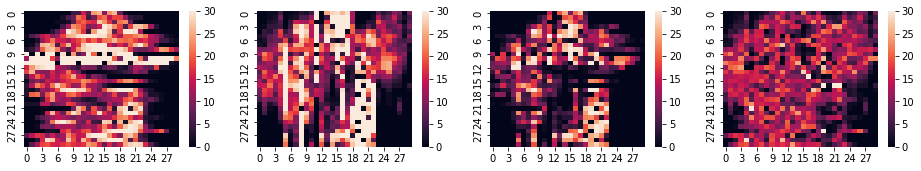

max fitness:  230 138
max fitness:  227 141
max fitness:  230 138
max fitness:  230 138
max fitness:  231 137
max fitness:  234 134
max fitness:  230 138
max fitness:  231 137
max fitness:  230 138
max fitness:  228 140
max fitness:  229 139
max fitness:  231 137
max fitness:  226 142
max fitness:  230 138
max fitness:  236 132
max fitness:  233 135
max fitness:  223 145
max fitness:  229 139
max fitness:  229 139
max fitness:  228 140
max fitness:  225 143
max fitness:  228 140
max fitness:  230 138
max fitness:  229 139
max fitness:  230 138
max fitness:  229 139
max fitness:  226 142
max fitness:  228 140
max fitness:  229 139
max fitness:  228 140


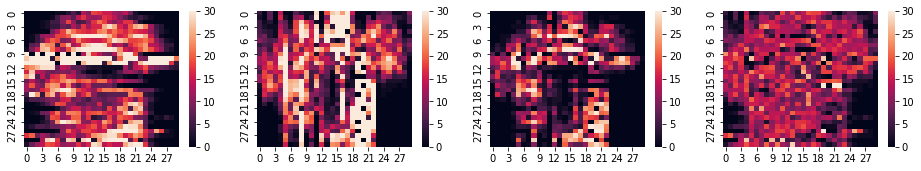

max fitness:  232 136
max fitness:  224 144
max fitness:  227 141
max fitness:  229 139
max fitness:  230 138
max fitness:  230 138
max fitness:  228 140
max fitness:  226 142
max fitness:  229 139
max fitness:  229 139
max fitness:  229 139
max fitness:  228 140
max fitness:  231 137
max fitness:  230 138
max fitness:  229 139
max fitness:  228 140
max fitness:  228 140
max fitness:  235 133
max fitness:  230 138
max fitness:  230 138
max fitness:  229 139
max fitness:  227 141
max fitness:  227 141
max fitness:  230 138
max fitness:  228 140
max fitness:  225 143
max fitness:  225 143
max fitness:  224 144
max fitness:  227 141
max fitness:  231 137


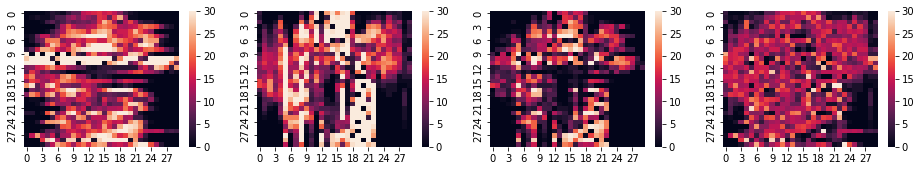

max fitness:  226 142
max fitness:  238 130
max fitness:  227 141
max fitness:  225 143
max fitness:  228 140
max fitness:  228 140
max fitness:  227 141
max fitness:  230 138
max fitness:  225 143
max fitness:  227 141
max fitness:  226 142
max fitness:  224 144
max fitness:  231 137
max fitness:  223 145
max fitness:  225 143
max fitness:  224 144
max fitness:  226 142
max fitness:  229 139
max fitness:  226 142
max fitness:  233 135
max fitness:  225 143
max fitness:  224 144
max fitness:  226 142
max fitness:  231 137
max fitness:  227 141
max fitness:  226 142
max fitness:  229 139
max fitness:  228 140
max fitness:  226 142
max fitness:  228 140


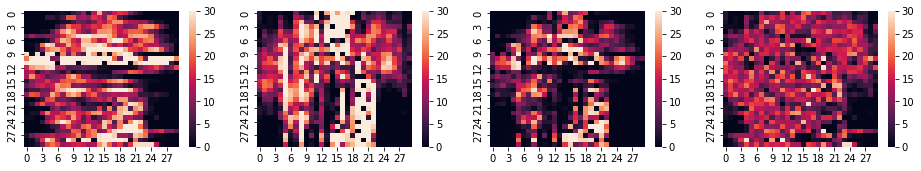

max fitness:  233 135
max fitness:  227 141
max fitness:  228 140
max fitness:  232 136
max fitness:  228 140
max fitness:  226 142
max fitness:  224 144
max fitness:  231 137
max fitness:  228 140
max fitness:  225 143
max fitness:  226 142
max fitness:  223 145
max fitness:  225 143
max fitness:  222 146
max fitness:  221 147
max fitness:  223 145
max fitness:  233 135
max fitness:  225 143
max fitness:  225 143
max fitness:  224 144
max fitness:  225 143
max fitness:  228 140
max fitness:  226 142
max fitness:  233 135
max fitness:  228 140
max fitness:  233 135
max fitness:  232 136
max fitness:  232 136
max fitness:  232 136
max fitness:  227 141


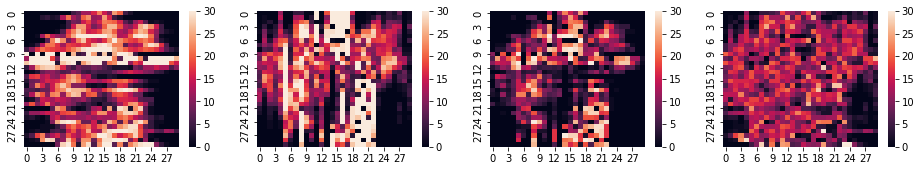

max fitness:  228 140
max fitness:  230 138
max fitness:  230 138
max fitness:  229 139
max fitness:  225 143
max fitness:  227 141
max fitness:  227 141
max fitness:  228 140
max fitness:  231 137
max fitness:  228 140
max fitness:  228 140
max fitness:  230 138
max fitness:  232 136
max fitness:  235 133
max fitness:  234 134
max fitness:  229 139
max fitness:  232 136
max fitness:  233 135
max fitness:  226 142
max fitness:  229 139
max fitness:  231 137
max fitness:  230 138
max fitness:  225 143
max fitness:  231 137
max fitness:  228 140
max fitness:  231 137
max fitness:  234 134
max fitness:  227 141
max fitness:  233 135
max fitness:  226 142


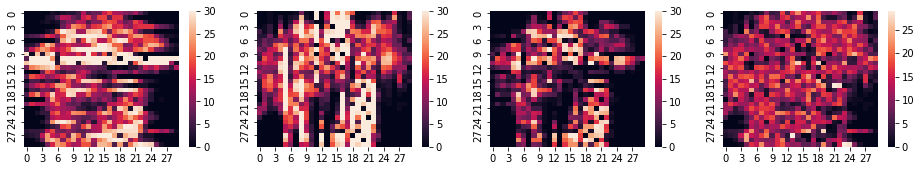

max fitness:  232 136
max fitness:  226 142
max fitness:  232 136
max fitness:  228 140
max fitness:  230 138
max fitness:  226 142
max fitness:  226 142
max fitness:  228 140
max fitness:  230 138
max fitness:  229 139
max fitness:  238 130
max fitness:  229 139
max fitness:  231 137
max fitness:  238 130
max fitness:  235 133
max fitness:  230 138
max fitness:  232 136
max fitness:  236 132
max fitness:  229 139
max fitness:  233 135
max fitness:  228 140
max fitness:  234 134
max fitness:  229 139
max fitness:  234 134
max fitness:  231 137
max fitness:  227 141
max fitness:  228 140
max fitness:  229 139
max fitness:  229 139
max fitness:  232 136


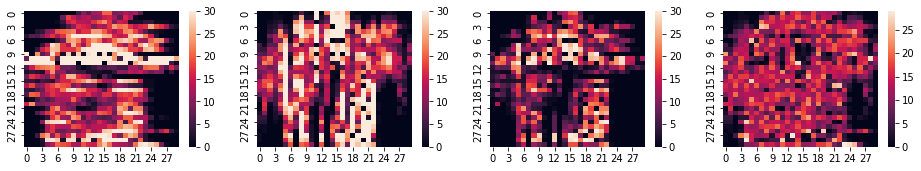

max fitness:  231 137
max fitness:  228 140
max fitness:  227 141
max fitness:  229 139
max fitness:  229 139
max fitness:  227 141
max fitness:  232 136
max fitness:  227 141
max fitness:  230 138
max fitness:  228 140
max fitness:  227 141
max fitness:  223 145
max fitness:  231 137
max fitness:  222 146
max fitness:  224 144
max fitness:  227 141
max fitness:  235 133
max fitness:  228 140
max fitness:  222 146
max fitness:  224 144
max fitness:  227 141
max fitness:  225 143
max fitness:  230 138
max fitness:  224 144
max fitness:  227 141
max fitness:  229 139
max fitness:  229 139
max fitness:  226 142
max fitness:  226 142
max fitness:  227 141


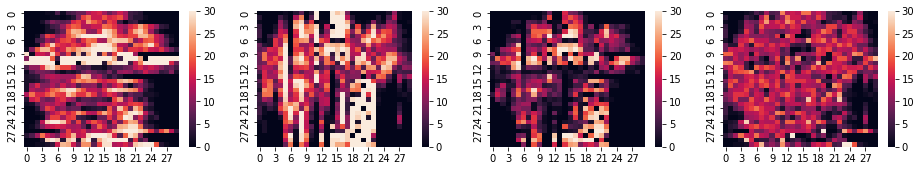

max fitness:  226 142
max fitness:  226 142
max fitness:  228 140
max fitness:  227 141
max fitness:  225 143
max fitness:  232 136
max fitness:  227 141
max fitness:  228 140
max fitness:  226 142
max fitness:  229 139
max fitness:  231 137
max fitness:  225 143
max fitness:  227 141
max fitness:  224 144
max fitness:  230 138
max fitness:  227 141
max fitness:  230 138
max fitness:  225 143
max fitness:  225 143
max fitness:  228 140
max fitness:  232 136
max fitness:  228 140
max fitness:  227 141
max fitness:  228 140
max fitness:  235 133
max fitness:  231 137
max fitness:  234 134
max fitness:  237 131
max fitness:  231 137
max fitness:  228 140


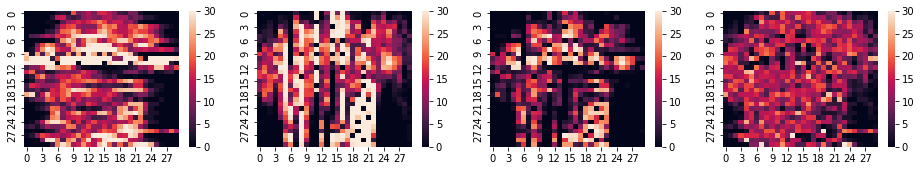

max fitness:  228 140
max fitness:  228 140
max fitness:  228 140
max fitness:  229 139
max fitness:  230 138
max fitness:  227 141
max fitness:  225 143
max fitness:  229 139
max fitness:  223 145
max fitness:  227 141
max fitness:  226 142
max fitness:  226 142
max fitness:  225 143
max fitness:  237 131
max fitness:  226 142
max fitness:  233 135
max fitness:  222 146
max fitness:  223 145
max fitness:  229 139
max fitness:  229 139
max fitness:  229 139
max fitness:  235 133
max fitness:  227 141
max fitness:  232 136
max fitness:  239 129
max fitness:  232 136
max fitness:  224 144
max fitness:  228 140
max fitness:  229 139
max fitness:  227 141


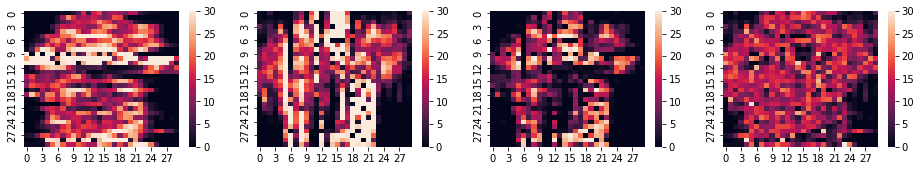

max fitness:  234 134
max fitness:  229 139
max fitness:  231 137
max fitness:  226 142
max fitness:  227 141
max fitness:  230 138
max fitness:  228 140
max fitness:  227 141
max fitness:  226 142
max fitness:  226 142
max fitness:  237 131
max fitness:  231 137
max fitness:  227 141
max fitness:  228 140
max fitness:  224 144
max fitness:  228 140
max fitness:  228 140
max fitness:  226 142
max fitness:  227 141
max fitness:  226 142
max fitness:  229 139
max fitness:  225 143
max fitness:  227 141
max fitness:  223 145
max fitness:  229 139
max fitness:  226 142
max fitness:  231 137
max fitness:  225 143
max fitness:  228 140
max fitness:  233 135


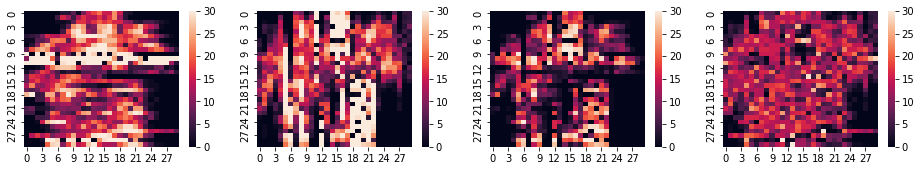

max fitness:  234 134
max fitness:  238 130
max fitness:  227 141
max fitness:  229 139
max fitness:  225 143
max fitness:  226 142
max fitness:  224 144
max fitness:  224 144
max fitness:  226 142
max fitness:  222 146
max fitness:  225 143
max fitness:  226 142
max fitness:  222 146
max fitness:  222 146
max fitness:  224 144
max fitness:  225 143
max fitness:  222 146
max fitness:  222 146
max fitness:  226 142
max fitness:  225 143
max fitness:  226 142
max fitness:  227 141
max fitness:  225 143
max fitness:  225 143
max fitness:  222 146
max fitness:  221 147
max fitness:  223 145
max fitness:  222 146
max fitness:  223 145
max fitness:  225 143


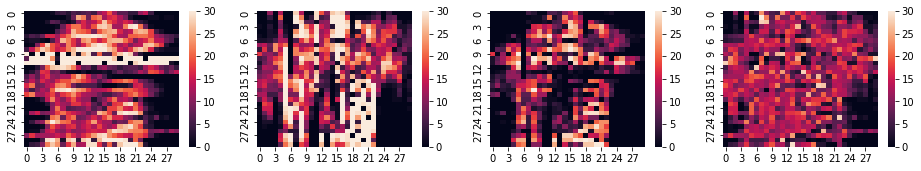

max fitness:  223 145
max fitness:  227 141
max fitness:  227 141
max fitness:  224 144
max fitness:  225 143
max fitness:  225 143
max fitness:  222 146
max fitness:  224 144
max fitness:  225 143
max fitness:  227 141
max fitness:  224 144
max fitness:  231 137
max fitness:  224 144
max fitness:  220 148
max fitness:  224 144
max fitness:  222 146
max fitness:  224 144
max fitness:  228 140
max fitness:  221 147
max fitness:  226 142
max fitness:  224 144
max fitness:  224 144
max fitness:  226 142
max fitness:  222 146
max fitness:  227 141
max fitness:  239 129
max fitness:  225 143
max fitness:  224 144
max fitness:  224 144
max fitness:  230 138


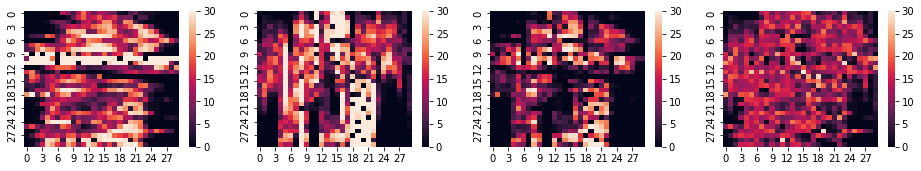

max fitness:  229 139
max fitness:  225 143
max fitness:  227 141
max fitness:  226 142
max fitness:  227 141
max fitness:  231 137
max fitness:  224 144
max fitness:  229 139
max fitness:  229 139
max fitness:  223 145
max fitness:  227 141
max fitness:  224 144
max fitness:  226 142
max fitness:  227 141
max fitness:  224 144
max fitness:  227 141
max fitness:  223 145
max fitness:  223 145
max fitness:  222 146
max fitness:  223 145
max fitness:  222 146
max fitness:  222 146
max fitness:  228 140
max fitness:  227 141
max fitness:  227 141
max fitness:  229 139
max fitness:  229 139
max fitness:  232 136
max fitness:  229 139
max fitness:  227 141


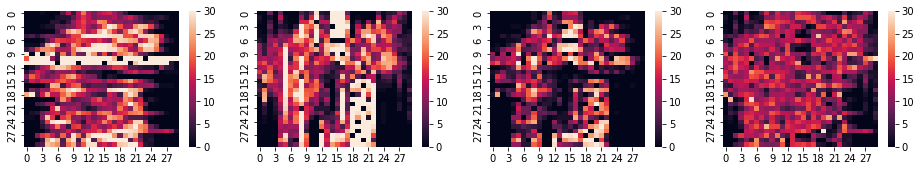

max fitness:  230 138
max fitness:  229 139
max fitness:  226 142
max fitness:  224 144
max fitness:  229 139
max fitness:  229 139
max fitness:  231 137
max fitness:  231 137
max fitness:  227 141
max fitness:  230 138
max fitness:  233 135
max fitness:  229 139
max fitness:  232 136
max fitness:  239 129
max fitness:  233 135
max fitness:  234 134
max fitness:  238 130
max fitness:  231 137
max fitness:  236 132
max fitness:  242 126
max fitness:  231 137
max fitness:  233 135
max fitness:  235 133
max fitness:  235 133
max fitness:  233 135
max fitness:  234 134
max fitness:  234 134
max fitness:  231 137
max fitness:  232 136
max fitness:  236 132


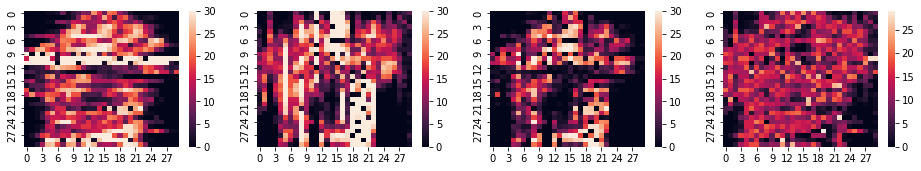

max fitness:  231 137
max fitness:  227 141
max fitness:  234 134
max fitness:  230 138
max fitness:  228 140
max fitness:  232 136
max fitness:  229 139
max fitness:  230 138
max fitness:  229 139
max fitness:  232 136
max fitness:  230 138
max fitness:  226 142
max fitness:  229 139
max fitness:  238 130
max fitness:  233 135
max fitness:  229 139
max fitness:  229 139
max fitness:  241 127
max fitness:  235 133
max fitness:  231 137
max fitness:  228 140
max fitness:  237 131
max fitness:  234 134
max fitness:  232 136
max fitness:  229 139
max fitness:  233 135
max fitness:  231 137
max fitness:  226 142
max fitness:  230 138
max fitness:  227 141


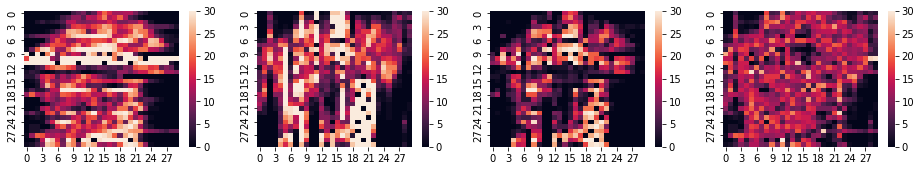

max fitness:  231 137
max fitness:  234 134
max fitness:  230 138
max fitness:  231 137
max fitness:  230 138
max fitness:  230 138
max fitness:  230 138
max fitness:  232 136
max fitness:  226 142
max fitness:  227 141
max fitness:  228 140
max fitness:  231 137
max fitness:  229 139
max fitness:  230 138
max fitness:  231 137
max fitness:  231 137
max fitness:  226 142
max fitness:  229 139
max fitness:  229 139
max fitness:  230 138
max fitness:  233 135
max fitness:  226 142
max fitness:  229 139
max fitness:  228 140
max fitness:  229 139
max fitness:  229 139
max fitness:  227 141
max fitness:  228 140
max fitness:  227 141
max fitness:  226 142


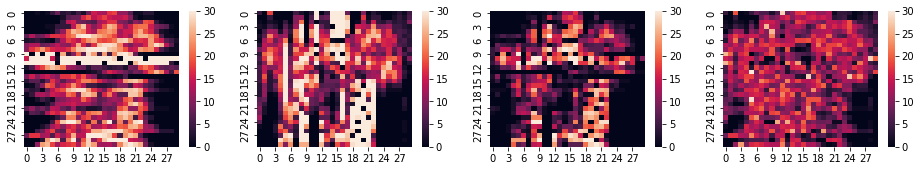

max fitness:  230 138
max fitness:  228 140
max fitness:  228 140
max fitness:  229 139
max fitness:  225 143
max fitness:  230 138
max fitness:  223 145
max fitness:  226 142
max fitness:  227 141
max fitness:  231 137
max fitness:  226 142
max fitness:  225 143
max fitness:  227 141
max fitness:  231 137
max fitness:  231 137
max fitness:  229 139
max fitness:  225 143
max fitness:  226 142
max fitness:  227 141
max fitness:  228 140
max fitness:  232 136
max fitness:  224 144
max fitness:  230 138
max fitness:  228 140
max fitness:  227 141
max fitness:  228 140
max fitness:  230 138
max fitness:  229 139
max fitness:  228 140
max fitness:  225 143


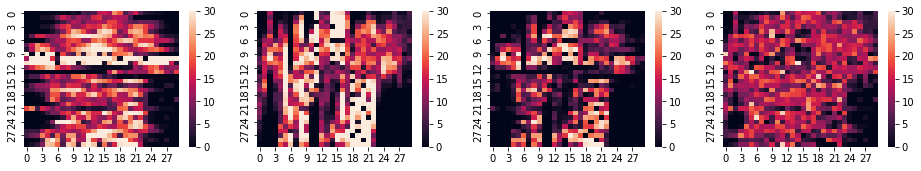

max fitness:  227 141
max fitness:  225 143
max fitness:  227 141
max fitness:  228 140
max fitness:  226 142
max fitness:  230 138
max fitness:  225 143
max fitness:  226 142
max fitness:  225 143
max fitness:  235 133
max fitness:  230 138
max fitness:  225 143
max fitness:  228 140
max fitness:  229 139
max fitness:  229 139
max fitness:  233 135
max fitness:  230 138
max fitness:  233 135
max fitness:  232 136
max fitness:  230 138
max fitness:  228 140
max fitness:  229 139
max fitness:  228 140
max fitness:  228 140
max fitness:  229 139
max fitness:  224 144
max fitness:  226 142
max fitness:  232 136
max fitness:  230 138
max fitness:  230 138


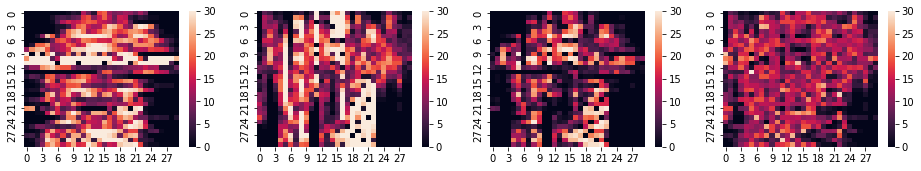

max fitness:  230 138
max fitness:  229 139
max fitness:  231 137
max fitness:  232 136
max fitness:  229 139
max fitness:  225 143
max fitness:  228 140
max fitness:  236 132
max fitness:  225 143
max fitness:  237 131
max fitness:  233 135
max fitness:  228 140
max fitness:  231 137
max fitness:  233 135
max fitness:  230 138
max fitness:  234 134
max fitness:  231 137
max fitness:  233 135
max fitness:  232 136
max fitness:  230 138
max fitness:  232 136
max fitness:  234 134
max fitness:  231 137
max fitness:  230 138
max fitness:  234 134
max fitness:  229 139
max fitness:  234 134
max fitness:  231 137
max fitness:  227 141
max fitness:  228 140


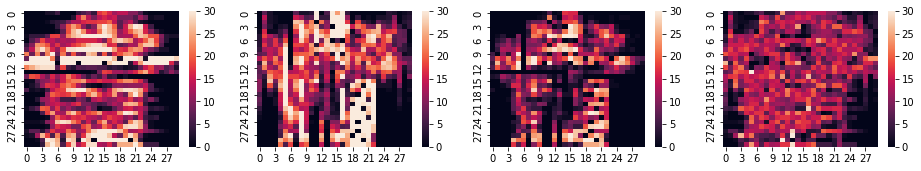

max fitness:  231 137
max fitness:  235 133
max fitness:  227 141
max fitness:  229 139
max fitness:  229 139
max fitness:  229 139
max fitness:  234 134
max fitness:  231 137
max fitness:  234 134
max fitness:  229 139
max fitness:  232 136
max fitness:  226 142
max fitness:  233 135
max fitness:  232 136
max fitness:  227 141
max fitness:  231 137
max fitness:  230 138
max fitness:  235 133
max fitness:  229 139
max fitness:  228 140
max fitness:  228 140
max fitness:  227 141
max fitness:  228 140
max fitness:  226 142
max fitness:  230 138
max fitness:  230 138
max fitness:  231 137
max fitness:  227 141
max fitness:  228 140
max fitness:  229 139


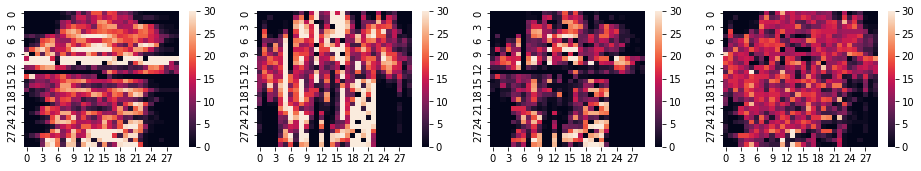

max fitness:  229 139
max fitness:  228 140
max fitness:  226 142
max fitness:  227 141
max fitness:  228 140
max fitness:  236 132
max fitness:  227 141
max fitness:  224 144
max fitness:  225 143
max fitness:  230 138
max fitness:  230 138
max fitness:  231 137
max fitness:  228 140
max fitness:  228 140
max fitness:  225 143
max fitness:  225 143
max fitness:  226 142
max fitness:  226 142
max fitness:  229 139
max fitness:  226 142
max fitness:  230 138
max fitness:  230 138
max fitness:  232 136
max fitness:  238 130
max fitness:  234 134
max fitness:  234 134
max fitness:  233 135
max fitness:  232 136
max fitness:  230 138
max fitness:  235 133


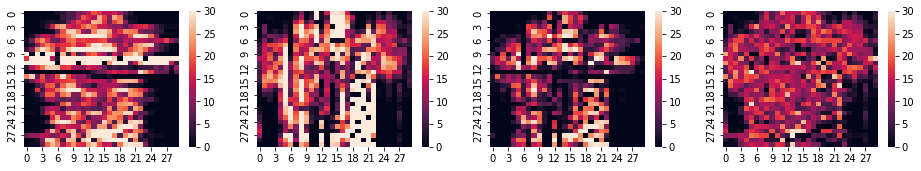

max fitness:  240 128
max fitness:  233 135
max fitness:  236 132
max fitness:  234 134
max fitness:  228 140
max fitness:  231 137
max fitness:  233 135
max fitness:  238 130
max fitness:  231 137
max fitness:  229 139
max fitness:  227 141
max fitness:  227 141
max fitness:  228 140
max fitness:  234 134
max fitness:  230 138
max fitness:  228 140
max fitness:  236 132
max fitness:  230 138
max fitness:  229 139
max fitness:  234 134
max fitness:  228 140
max fitness:  226 142
max fitness:  234 134
max fitness:  226 142
max fitness:  227 141
max fitness:  225 143
max fitness:  226 142
max fitness:  223 145
max fitness:  225 143
max fitness:  225 143


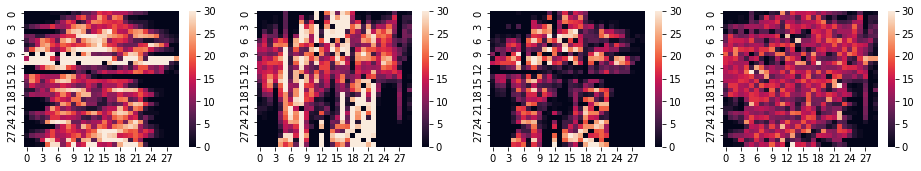

max fitness:  228 140
max fitness:  231 137
max fitness:  226 142
max fitness:  226 142
max fitness:  228 140
max fitness:  225 143
max fitness:  222 146
max fitness:  222 146
max fitness:  227 141
max fitness:  223 145
max fitness:  219 149
max fitness:  224 144
max fitness:  225 143
max fitness:  224 144
max fitness:  225 143
max fitness:  224 144
max fitness:  225 143
max fitness:  226 142
max fitness:  225 143
max fitness:  226 142
max fitness:  232 136
max fitness:  227 141
max fitness:  231 137
max fitness:  229 139
max fitness:  228 140
max fitness:  224 144
max fitness:  230 138
max fitness:  225 143
max fitness:  228 140
max fitness:  226 142


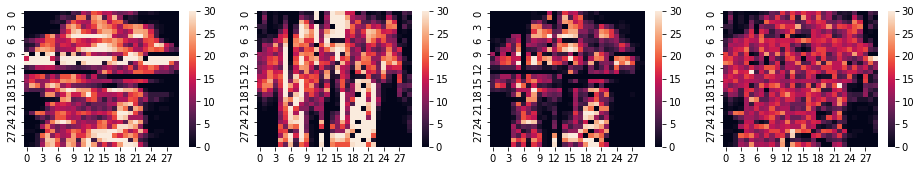

max fitness:  229 139
max fitness:  230 138
max fitness:  230 138
max fitness:  228 140
max fitness:  227 141
max fitness:  228 140
max fitness:  238 130
max fitness:  237 131
max fitness:  233 135
max fitness:  231 137
max fitness:  230 138
max fitness:  231 137
max fitness:  231 137
max fitness:  229 139
max fitness:  234 134
max fitness:  234 134
max fitness:  232 136
max fitness:  229 139
max fitness:  238 130
max fitness:  231 137
max fitness:  231 137
max fitness:  235 133
max fitness:  237 131
max fitness:  233 135
max fitness:  235 133
max fitness:  230 138
max fitness:  235 133
max fitness:  231 137
max fitness:  230 138
max fitness:  228 140


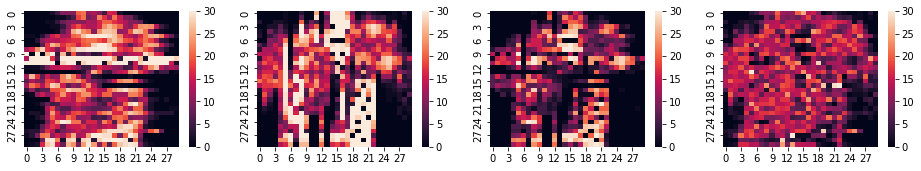

max fitness:  235 133
max fitness:  234 134
max fitness:  230 138
max fitness:  232 136
max fitness:  234 134
max fitness:  231 137
max fitness:  236 132
max fitness:  232 136
max fitness:  233 135
max fitness:  232 136
max fitness:  228 140
max fitness:  230 138
max fitness:  231 137
max fitness:  232 136
max fitness:  232 136
max fitness:  235 133
max fitness:  235 133
max fitness:  231 137
max fitness:  229 139
max fitness:  229 139
max fitness:  229 139
max fitness:  230 138
max fitness:  230 138
max fitness:  226 142
max fitness:  227 141
max fitness:  230 138
max fitness:  231 137
max fitness:  231 137
max fitness:  234 134
max fitness:  236 132


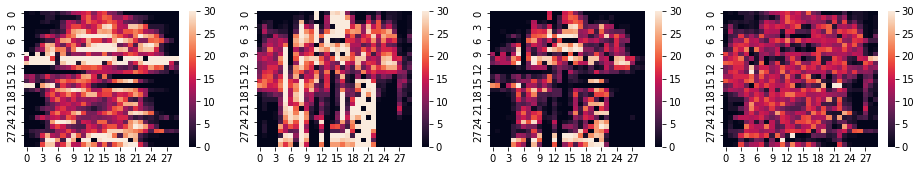

max fitness:  229 139
max fitness:  228 140
max fitness:  234 134
max fitness:  235 133
max fitness:  231 137
max fitness:  231 137
max fitness:  233 135
max fitness:  231 137
max fitness:  231 137
max fitness:  230 138
max fitness:  241 127
max fitness:  238 130
max fitness:  233 135
max fitness:  233 135
max fitness:  231 137
max fitness:  232 136
max fitness:  232 136
max fitness:  230 138
max fitness:  231 137
max fitness:  229 139
max fitness:  232 136
max fitness:  235 133
max fitness:  228 140
max fitness:  227 141
max fitness:  225 143
max fitness:  228 140
max fitness:  226 142
max fitness:  229 139
max fitness:  228 140
max fitness:  230 138


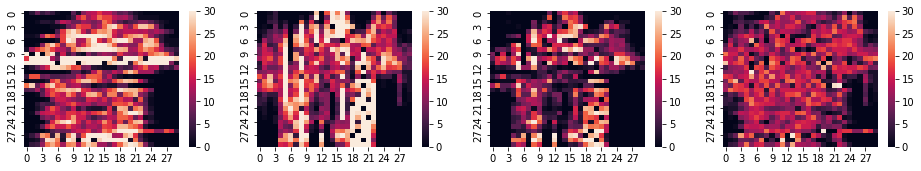

max fitness:  232 136
max fitness:  230 138
max fitness:  226 142
max fitness:  230 138
max fitness:  230 138
max fitness:  228 140
max fitness:  230 138
max fitness:  226 142
max fitness:  233 135
max fitness:  229 139
max fitness:  229 139
max fitness:  232 136
max fitness:  232 136
max fitness:  225 143
max fitness:  226 142
max fitness:  229 139
max fitness:  224 144
max fitness:  229 139
max fitness:  226 142
max fitness:  228 140
max fitness:  227 141
max fitness:  233 135
max fitness:  226 142
max fitness:  231 137
max fitness:  228 140
max fitness:  225 143
max fitness:  230 138
max fitness:  235 133
max fitness:  224 144
max fitness:  230 138


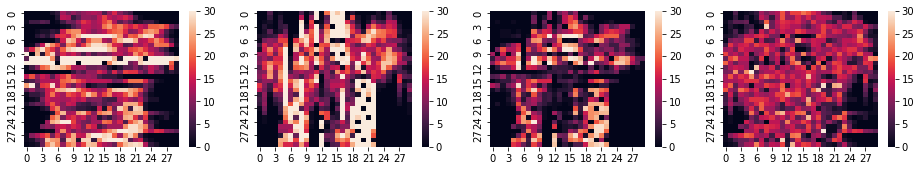

max fitness:  224 144
max fitness:  231 137
max fitness:  232 136
max fitness:  228 140
max fitness:  235 133
max fitness:  228 140
max fitness:  229 139
max fitness:  228 140
max fitness:  230 138
max fitness:  229 139
max fitness:  230 138
max fitness:  230 138
max fitness:  234 134
max fitness:  234 134
max fitness:  234 134
max fitness:  229 139
max fitness:  233 135
max fitness:  235 133
max fitness:  234 134
max fitness:  234 134
max fitness:  236 132
max fitness:  230 138
max fitness:  240 128
max fitness:  231 137
max fitness:  225 143
max fitness:  232 136
max fitness:  232 136
max fitness:  229 139
max fitness:  229 139
max fitness:  228 140


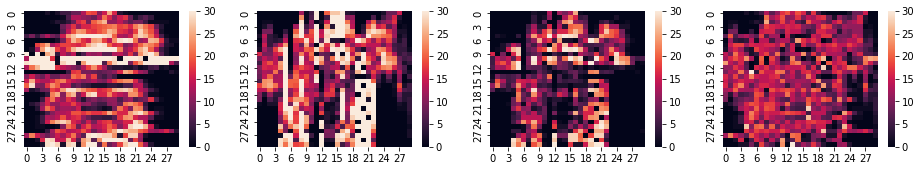

max fitness:  232 136
max fitness:  229 139
max fitness:  230 138
max fitness:  234 134
max fitness:  231 137
max fitness:  234 134
max fitness:  234 134
max fitness:  234 134
max fitness:  233 135
max fitness:  234 134
max fitness:  237 131
max fitness:  228 140
max fitness:  234 134
max fitness:  231 137
max fitness:  232 136
max fitness:  241 127
max fitness:  229 139
max fitness:  231 137
max fitness:  233 135
max fitness:  230 138
max fitness:  236 132
max fitness:  238 130
max fitness:  235 133
max fitness:  232 136
max fitness:  237 131
max fitness:  235 133
max fitness:  236 132
max fitness:  233 135
max fitness:  232 136
max fitness:  236 132


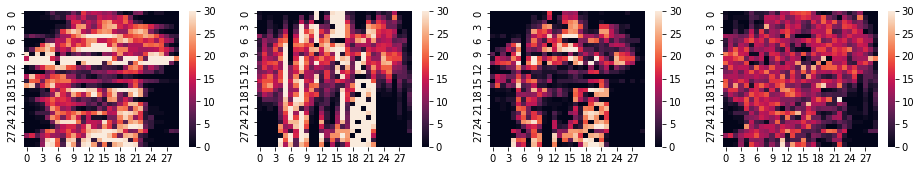

max fitness:  232 136
max fitness:  233 135
max fitness:  239 129
max fitness:  230 138
max fitness:  233 135
max fitness:  235 133
max fitness:  231 137
max fitness:  231 137
max fitness:  231 137
max fitness:  232 136
max fitness:  231 137
max fitness:  232 136
max fitness:  228 140
max fitness:  237 131
max fitness:  231 137
max fitness:  230 138
max fitness:  231 137
max fitness:  228 140
max fitness:  234 134
max fitness:  233 135
max fitness:  233 135
max fitness:  232 136
max fitness:  229 139
max fitness:  235 133
max fitness:  234 134
max fitness:  231 137
max fitness:  235 133
max fitness:  232 136
max fitness:  231 137
max fitness:  229 139


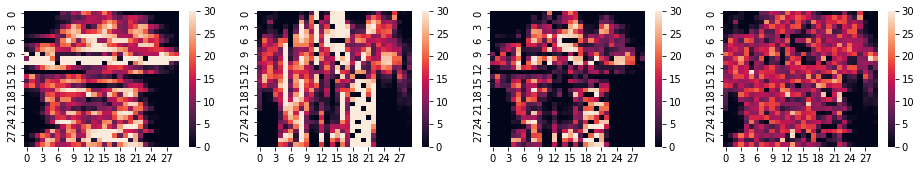

max fitness:  231 137
max fitness:  233 135
max fitness:  233 135
max fitness:  230 138
max fitness:  231 137
max fitness:  234 134
max fitness:  233 135
max fitness:  236 132
max fitness:  237 131
max fitness:  231 137
max fitness:  233 135
max fitness:  234 134
max fitness:  229 139
max fitness:  227 141
max fitness:  230 138
max fitness:  235 133
max fitness:  234 134
max fitness:  234 134
max fitness:  239 129
max fitness:  234 134
max fitness:  229 139
max fitness:  235 133
max fitness:  232 136
max fitness:  235 133
max fitness:  234 134
max fitness:  235 133
max fitness:  231 137
max fitness:  234 134
max fitness:  235 133
max fitness:  229 139


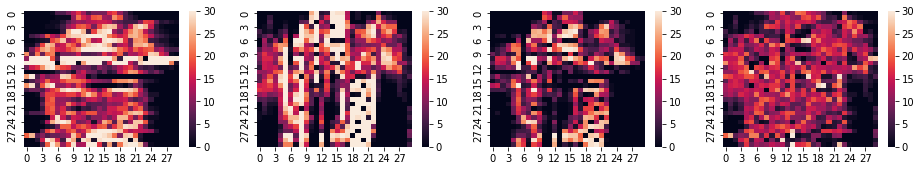

max fitness:  232 136
max fitness:  235 133
max fitness:  232 136
max fitness:  231 137
max fitness:  234 134
max fitness:  236 132
max fitness:  231 137
max fitness:  234 134
max fitness:  231 137
max fitness:  235 133
max fitness:  231 137
max fitness:  231 137
max fitness:  233 135
max fitness:  230 138
max fitness:  234 134
max fitness:  233 135
max fitness:  232 136
max fitness:  235 133
max fitness:  235 133
max fitness:  240 128
max fitness:  234 134
max fitness:  235 133
max fitness:  233 135
max fitness:  233 135
max fitness:  229 139
max fitness:  232 136
max fitness:  233 135
max fitness:  235 133
max fitness:  231 137
max fitness:  232 136


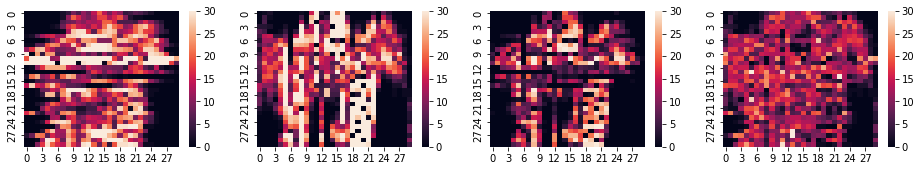

max fitness:  235 133
max fitness:  228 140
max fitness:  233 135
max fitness:  230 138
max fitness:  233 135
max fitness:  228 140
max fitness:  229 139
max fitness:  230 138
max fitness:  228 140
max fitness:  228 140
max fitness:  236 132
max fitness:  229 139
max fitness:  227 141
max fitness:  230 138
max fitness:  230 138
max fitness:  231 137
max fitness:  229 139
max fitness:  238 130
max fitness:  230 138
max fitness:  232 136
max fitness:  228 140
max fitness:  236 132
max fitness:  235 133
max fitness:  229 139
max fitness:  233 135
max fitness:  234 134
max fitness:  233 135
max fitness:  232 136
max fitness:  230 138
max fitness:  235 133


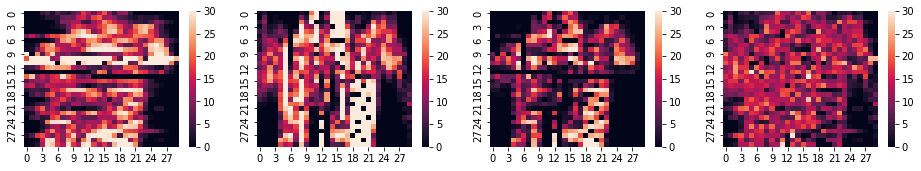

max fitness:  232 136
max fitness:  229 139
max fitness:  228 140
max fitness:  229 139
max fitness:  230 138
max fitness:  229 139
max fitness:  233 135
max fitness:  238 130
max fitness:  228 140
max fitness:  228 140
max fitness:  234 134
max fitness:  229 139
max fitness:  232 136
max fitness:  232 136
max fitness:  227 141
max fitness:  231 137
max fitness:  229 139
max fitness:  226 142
max fitness:  227 141
max fitness:  229 139
max fitness:  232 136
max fitness:  236 132
max fitness:  230 138


KeyboardInterrupt: 

In [8]:
aic = AIC(M)
air = AIR(M)

nai = 30
nchildren = 100
niteration = 10000
nshuffle = 10
mrate = 0.975

ais = np.array([AI(M,aic,air) for _ in range(nai)])
goal = ais[0].goal
print('***goal**** ')
print(goal)


for n in range(niteration):
    
    S1, S2 = np.vstack([np.random.choice(ais,2,replace=False) for _ in range(nchildren)]).T    
    ais = AI.crossover(S1, S2,mrate = mrate)
    
    
    for _ in range(nshuffle):
        s1,s2 = np.random.choice(ais,2,replace=False)
        s1._C, s2._C = s2._C, s1._C
        

        
    fitness = list(map(lambda x: x.fitness,ais))
    ais = ais[np.argsort(fitness)[::-1][:nai]]
    
    print('max fitness: ',np.max(fitness), goal - np.max(fitness))    
    if(not n%30):
        fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (16,2.5))
        sns.heatmap(np.sum(np.array([ai.C for ai in ais]),0),ax = ax1)
        sns.heatmap(np.sum(np.array([ai.R for ai in ais]),0),ax = ax2)
        sns.heatmap(np.sum(np.array([ai.C & ai.R for ai in ais]),0),ax = ax3)
        sns.heatmap(np.sum(np.array([ai.C ^ ai.R for ai in ais]),0),ax = ax4)
        plt.show()



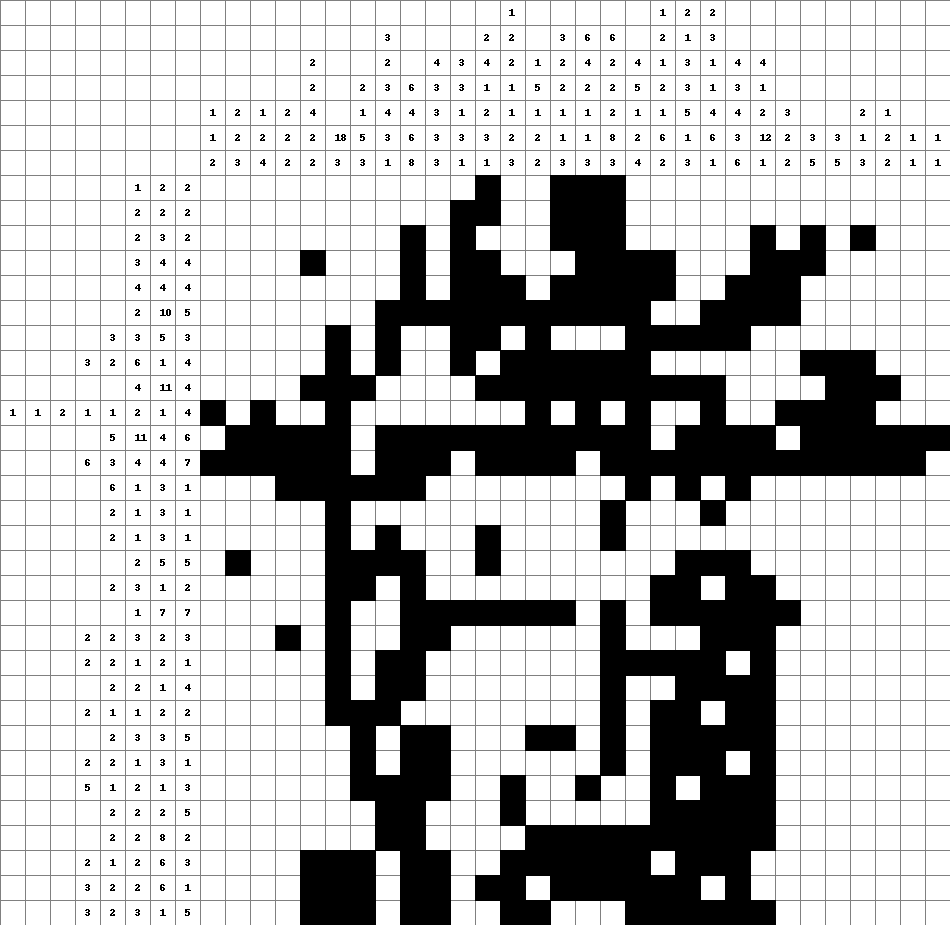

In [28]:
M.Mdraw((np.sum(np.array([ai.C for ai in ais]),0) > 65) | (np.sum(np.array([ai.R for ai in ais]),0) > 65))